**Intelligent Systems for Pattern Recognition Course - Midterm 3**
## Denoising and Contractive Autoencoder - Assignment 1
Giulia Ghisolfi, role number: 664266

In [1]:
# load mnist data
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as patheffects
import numpy as np
import random

RANDOM_SEED = 42

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Import dataset:

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, labels) = mnist.load_data()

In [3]:
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

Data normalization:

In [4]:
# normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

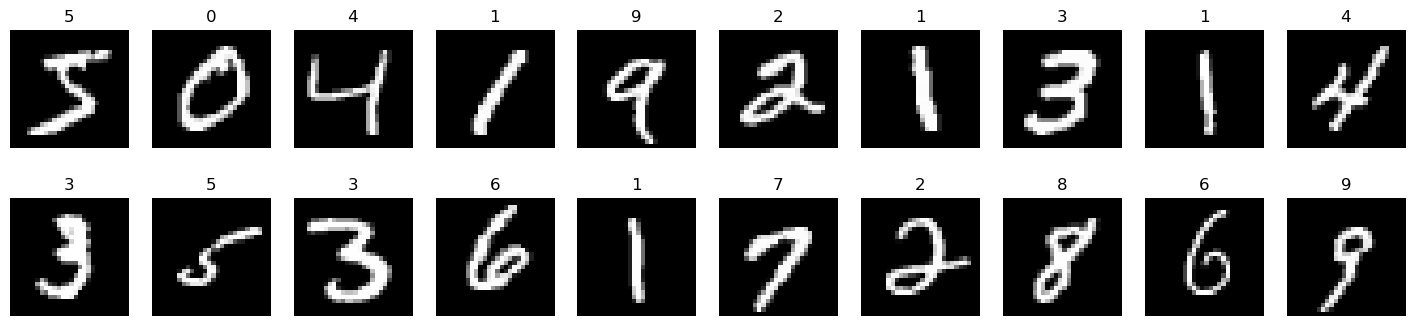

In [5]:
# visualize train data
fig, axes = plt.subplots(2, 10, figsize=(18, 4))
for i in range(20):
    ax = axes[i//10, i%10]
    ax.imshow(train_images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(train_labels[i])

In [6]:
train_images[0].min(), train_images[0].max(), train_images[0].shape

(0.0, 1.0, (28, 28))

## Code Implementation

Firstly, we implemented an `Autoencoder` class for image reconstruction, offering the flexibility to choose between convolutional or dense layers based on input parameters.

The class has been further extended to construct a `Denoising Autoencoder` (DAE) and a `Contractive Autoencoder` (CAE), expanding its capabilities for representation learning and image reconstruction tasks.

### Autoencoder

In [7]:
class MetricsLogger(Callback):
    """
    A custom callback to log the loss and accuracy of the model
    Args:
        Callback: Keras Callback class
    """
    def on_train_batch_end(self, batch, logs=None):
        if logs is not None:
            for key, value in logs.items():
                self.model.history.history.setdefault(key, []).append(value)

In [8]:
def add_noise(image, sigma=0.1):
    """
    Add gaussian noise to the image with the given standard deviation and mean 0
    Args:
        image: 2D numpy array
        sigma: standard deviation of the gaussian noise
    """
    noise = np.random.normal(0, sigma, image.shape)
    return np.clip(image + noise, 0, 1) # clip the values to be between 0 and 1

In [56]:
class Autoencoder(Model):
    """
    Autoencoder model class for image reconstruction
    Based on the input parameters, the model can be either convolutional or dense

    Args:
        image_shape: tuple, shape of the input image
        convolutional_layers: boolean, if True, use convolutional layers, else use dense layers

    Methods:
        fit_autoencoder: fit the autoencoder model
        visualize_training: visualize the training and validation loss learning curve
        recostruct: reconstruct the images using the trained autoencoder
        visualize_reconstructed_images: visualize the original, corrupted and reconstructed images
    """
    def __init__(self, image_shape=(28, 28), convolutional_layers=True):
        super(Autoencoder, self).__init__()

        if convolutional_layers:
            self.encoder = tf.keras.Sequential([
                layers.Input(shape=(image_shape[0], image_shape[1], 1)),
                layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
                layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
                layers.Dense(8, activation='relu')
            ])

            self.decoder = tf.keras.Sequential([
                layers.Dense(8, activation='relu'),
                layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
                layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
                layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
            ])
        else:
            self.encoder = tf.keras.Sequential([
                layers.Flatten(),
                layers.Dense(128, activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
            ])
            
            self.decoder = tf.keras.Sequential([
                layers.Dense(64, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(784, activation='sigmoid'),
                layers.Reshape(image_shape)
            ])
    
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit_autoencoder(self, train_data, validation_fraction=0.2, mode='SGD', epochs=10, loss=losses.MeanSquaredError(),
        early_stopping=True, patience=10, batch_size=32, lr=0.01, momentum=0.9, **kwargs):
        """
        Fit the autoencoder model on the given data

        Args:
            train_data: 4D numpy array, training data
            validation_fraction: float, fraction of the data to be used for validation
            mode: str, optimizer to be used, 'SGD' or 'Adam'
            epochs: int, number of epochs to train the model
            loss: tf.keras.losses, loss function to be used
            early_stopping: boolean, if True, use early stopping
            patience: int, number of epochs to wait before stopping the training
            batch_size: int, batch size for training
            lr: float, learning rate for the optimizer
            momentum: float, momentum for the optimizer
        """
        if mode == 'SGD':
            self.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum),
            loss=loss)
        elif mode == 'Adam':
            self.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss=loss)
        else:
            raise ValueError('mode should be either "SGD" or "Adam"')
            
        # training
        if early_stopping:
            callbacks = [
                EarlyStopping(
                    monitor="val_loss",
                    min_delta=1e-5,
                    patience=patience,
                    verbose=0,
                    mode="auto",
                    baseline=None,
                    restore_best_weights=True,
                    start_from_epoch=0
                ),
                MetricsLogger()
            ]
        else:
            callbacks = [MetricsLogger()]
        
        self.steps_per_epoch = (train_data.shape[0] * (1-validation_fraction)) // batch_size
        self.history = self.fit(
            x=train_data,
            y=train_data,
            batch_size=batch_size,
            epochs=epochs,
            verbose="auto",
            callbacks=callbacks,
            validation_split=validation_fraction, # validation size
            shuffle=True,
            steps_per_epoch=self.steps_per_epoch)
        
        self.evaluation_metrics = self.evaluate(
            x=train_data,
            y=train_data,
            batch_size=batch_size,
            verbose="auto",
            return_dict=True)
        
    def visualize_training(self):
        plt.figure(figsize=(6, 3))
        plt.plot(self.history.history['loss'], label='train')
        x_val = np.arange(self.steps_per_epoch, len(self.history.history['loss']), self.steps_per_epoch)
        plt.plot(x_val, self.history.history['val_loss'], label='validation')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.show()
    
    def recostruct(self, test_data):
        return self.decoder(self.encoder(test_data).numpy()).numpy()
    
    def visualize_reconstructed_images(self, test_data, test_labels):
        if 'denoising' in self.name: n_rows=3
        else: n_rows=2
        fig, axes = plt.subplots(n_rows, 10, figsize=(18, 2*n_rows))
        image_to_visualize, labels = zip(*random.sample(list(zip(test_data, test_labels)), 10))

        if 'denoising' in self.name:
            corrupted_image_to_visualize = np.array([add_noise(image, self.sigma) for image in image_to_visualize])
            reconstructed_images = self.recostruct(np.array(corrupted_image_to_visualize))
        else:
            reconstructed_images = self.recostruct(np.array(image_to_visualize))

        for i in range(10):
            axes[0, i].imshow(image_to_visualize[i], cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title(f'Original {np.array(labels)[i]}')
            if 'denoising' in self.name:
                axes[1, i].imshow(corrupted_image_to_visualize[i], cmap='gray')
                axes[1, i].axis('off')
                axes[1, i].set_title('Corrupted')
            axes[n_rows-1, i].imshow(reconstructed_images[i], cmap='gray')
            axes[n_rows-1, i].axis('off')
            axes[n_rows-1, i].set_title('Reconstructed')

        fig.suptitle('Image Reconstruction')
        plt.show()

The `DenoisingAutoencoder` class extends the functionality of the base Autoencoder class to implement a Denoising Autoencoder model for image reconstruction tasks. The model adds Gaussian noise with a mean of 0 and a user-specified standard deviation to the input images before reconstruction, so it takes corrupted images as input and learn to reconstruct the images without noise.

In [10]:
class DenoisingAutoencoder(Autoencoder):
    """
    Denoising Autoencoder model class for image reconstruction
    Extends the Autoencoder class and adds the noise parameter

    Args:
        images_shape: tuple, shape of the input images
        sigma: float, standard deviation of the gaussian noise
        convolutional_layers: boolean, if True, use convolutional layers, else use dense layers
    """
    def __init__(self, images_shape=(28, 28), sigma=0.1, convolutional_layers=True):
        super().__init__(images_shape, convolutional_layers)
        self.sigma = sigma
    
    def fit_denoising_autoencoder(self, train_data, validation_fraction=0.2, mode='SGD', epochs=10, early_stopping=True,
        patience=10, batch_size=32, lr=0.01, momentum=0.9, **kwargs):
        """
        Fit the denoising autoencoder model on the given data
        
        Args:
            train_data: 4D numpy array, training data
            validation_fraction: float, fraction of the data to be used for validation
            mode: str, optimizer to be used, 'SGD' or 'Adam'
            epochs: int, number of epochs to train the model
            early_stopping: boolean, if True, use early stopping
            patience: int, number of epochs to wait before stopping the training
            batch_size: int, batch size for training
            lr: float, learning rate for the optimizer
            momentum: float, momentum for the optimizer
        """
        train_data_noisy = np.array([add_noise(image, self.sigma) for image in train_data])
        self.fit_autoencoder(train_data=train_data_noisy, validation_fraction=validation_fraction, mode=mode, epochs=epochs, 
            early_stopping=early_stopping, patience=patience, batch_size=batch_size, lr=lr, momentum=momentum, **kwargs)

The `ContractiveAutoencoder` class implements a type of autoencoder that employs a cost function with a contractive penalty during training. This mechanism penalizes the most sensitive activations, those with higher derivatives, making the contractive latent representation more robust to local variations in the input data.

In [72]:
class ContractiveAutoencoder(Autoencoder):
    """
    Contractive Autoencoder model class for image reconstruction
    Extends the Autoencoder class and adds the regularization parameter lambda
    
    Args:
        images_shape: tuple, shape of the input images
        lam: float, regularization parameter
        convolutional_layers: boolean, if True, use convolutional layers, else use dense layers
    """
    def __init__(self, images_shape=(28, 28), lam=1e-4, convolutional_layers=True):
        super().__init__(images_shape, convolutional_layers)
        self.lam = lam # lambda: regularization parameter

    def contractive_loss(self, y_true, y_pred):
        # compute a contractive loss function for the autoencoder adding a regularization term
        encoded = self.encoder(y_true)
        jacobian = tf.stack([tf.gradients(encoded[:, i], y_true)[0] for i in range(encoded.shape[1])], axis=1)
        jacobian = tf.reshape(jacobian, (y_true.shape[0], -1))
        return tf.reduce_mean(tf.square(y_true - y_pred)) + self.lam * tf.reduce_mean(tf.square(jacobian))

    def fit_contractive_autoencoder(self, train_data, validation_fraction=0.2, mode='SGD', epochs=10, early_stopping=True,
        patience=10, batch_size=32, lr=0.01, momentum=0.9, **kwargs):
        """
        Fit the contractive autoencoder model on the given data
        
        Args:
            train_data: 4D numpy array, training data
            validation_fraction: float, fraction of the data to be used for validation
            mode: str, optimizer to be used, 'SGD' or 'Adam'
            epochs: int, number of epochs to train the model
            early_stopping: boolean, if True, use early stopping
            patience: int, number of epochs to wait before stopping the training
            batch_size: int, batch size for training
            lr: float, learning rate for the optimizer
            momentum: float, momentum for the optimizer
        """
        self.fit_autoencoder(train_data=train_data, validation_fraction=validation_fraction, mode=mode, epochs=epochs,
            loss=self.contractive_loss, early_stopping=early_stopping, patience=patience, batch_size=batch_size, 
            lr=lr, momentum=momentum, **kwargs)

### T-distributed Stochastic Neighbor Embedding

We have also implemented t-SNE computation and visualization functions to gain a deeper understanding and interpret the performance of our models through the visualization of their encoded representations.

The t-Distributed Stochastic Neighbor Embedding technique is employed here to reducing the dimensionality of the encoded images while preserving their intrinsic structure.

We compute the t-SNE representation given encoded images as input, transforming high-dimensional encoded data into a format suitable for visualization.

By leveraging these functions, we can gain valuable insights into the latent space learned by our models, facilitating a deeper understanding of their performance and capabilities.

In [92]:
def compute_tsne(encoded_images, n_components=2):
    """
    Compute the TSNE of the encoded images

    Args:
        encoded_images: 3D numpy array, encoded images
        n_components: int, number of components for the TSNE (supported values: 1, 2)
    """
    encoded_images_flattened = encoded_images.reshape(encoded_images.shape[0], -1)

    # applying TSNE on data
    tsne = TSNE(n_components=n_components)
    encoded_images_tsne = tsne.fit_transform(encoded_images_flattened)

    return encoded_images_tsne

def visualize_tsne(encoded_images_tsne, labels, model_name, ax, s_size=6, fontsize=16):
    """
    Visualize the TSNE of the encoded images

    Args:
        encoded_images_tsne: 2D numpy array, encoded images after TSNE
        labels: 1D numpy array, labels of the images
        model_name: str, name of the model
        ax: matplotlib axis object
        s_size: int, size of the points in the scatter plot
        fontsize: int, font size of the labels
    """
    ax.scatter(encoded_images_tsne[:, 0], encoded_images_tsne[:, 1], c=labels, cmap='tab10', s=s_size)

    for i in range(10): # add labels to scatter plot
        color = plt.cm.tab10(i)
        ax.text(encoded_images_tsne[labels == i, 0].mean(),
            encoded_images_tsne[labels == i, 1].mean(), i, fontsize=fontsize, color=color, fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    ax.axis('off')
    return ax

def compute_and_visualize_tsne(encoded_images, labels, model_name, n_components=2):
    """
    Compute and visualize the TSNE of the encoded images
    
    Args:
        encoded_images: 3D numpy array, encoded images
        labels: 1D numpy array, labels of the images
        model_name: str, name of the model
        ax: matplotlib axis object
        n_components: int, number of components for the TSNE (supported values: 1, 2)
    """
    encoded_images_tsne = compute_tsne(encoded_images, n_components=n_components)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax = visualize_tsne(encoded_images_tsne, labels, model_name, ax=ax)
    ax.set_title(f'TSNE Visualization ({model_name})')
    plt.show()

In [95]:
def visualize_noise_image_on_tsne(encoded_images, labels, encoded_noise_image, model_name, ax, n_components=2):
    """
    Visualize the TSNE of the encoded images with the noise image
    
    Args:
        encoded_images: 3D numpy array, encoded images
        labels: 1D numpy array, labels of the images
        encoded_noise_image: 1D numpy array, encoded noise image
        model_name: str, name of the model
        n_components: int, number of components for the TSNE (supported values: 1, 2)
    """
    all_encoded_images = np.vstack((encoded_images, encoded_noise_image))
    encoded_images_tsne = compute_tsne(all_encoded_images, n_components=n_components)

    ax = visualize_tsne(encoded_images_tsne[:-1], labels, model_name, ax, s_size=2, fontsize=8)
    ax.scatter(encoded_images_tsne[-1][0], encoded_images_tsne[-1][1], c='black', s=15, marker='x')
    ax.text(encoded_images_tsne[-1][0]+1, encoded_images_tsne[-1][1], 'Noise Image', 
        fontsize=8, color='black', fontweight='bold',)

    ax.set_title(f'{model_name}')
    return ax
    

### Iterative gradient ascent process

The following function computes an iterative gradient ascent process to generate a new image from an initial random noise image. It iteratively updates the image, utilizing the learned representations of the autoencoder.

To facilitate visualization and analysis of this process, we have also implemented functions to observe the progression during each iteration.

In [14]:
def gradient_ascent(autoencoder, image, n_steps=100, lr=0.1, delta_steps=10):
    """
    Compute end visualize a iterative gradient ascent process to generate a new image from the given image

    Args:
        autoencoder: tf.keras.Model, autoencoder model
        image: 1D numpy array, input image
        n_steps: int, number of steps for the gradient ascent
        lr: float, learning rate for the optimizer
        delta_steps: int, number of steps between each visualization
    """
    image = image.reshape(1, 28, 28)

    n_rows = (((n_steps - 1) // delta_steps) + 1) // 10 + 1
    fig, axes = plt.subplots(n_rows, 10, figsize=(18, 2*n_rows))
    axes.flatten()[0].imshow(image.reshape(28, 28), cmap='gray')
    axes.flatten()[0].axis('off')
    axes.flatten()[0].set_title('Noise Image')

    for step in range(n_steps):
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(image)
            image = autoencoder(image)
            loss = tf.reduce_mean(image)
        gradients = tape.gradient(loss, image)
        gradients /= tf.norm(gradients)
        image += lr * gradients

        if step % delta_steps == 0:
            ax = axes.flatten()[step // delta_steps + 1]
            visualize_gradient_ascent(ax, image, step)

    fig.suptitle('Image Generation')
    plt.show()

def visualize_gradient_ascent(ax, image, step):
    ax.imshow(image.numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Step {step}')

## Training

This section contains the training of different autoencoders using various architectures and parameters. 

We first start by training a basic autoencoder with an encoder consisting of two convolutional layers with 16 and 8 filters respectively, both with a kernel size of 3x3, ReLU activation, and strides of 2, followed by a dense layer with 8 units and ReLU activation. The decoder mirrors this structure, beginning with a dense layer with 8 units and ReLU activation, followed by two transposed convolutional layers with 8 and 16 filters respectively, both with a kernel size of 3x3, ReLU activation, and strides of 2, and finally a convolutional layer with 1 filter, a kernel size of 3x3, and sigmoid activation.

This initial trial was done to establish a baseline for comparison with other architectures.

This same convolutional architecture was used in all convolutional autoencoders.

Subsequently, two tests were conducted using Denoising Autoencoders (DAE) and Contractive Autoencoders (CAE). For each type, two tests with different parameters and architectures were performed.

The parameters for all models were selected based on preliminary trials with certain parameters. An exhaustive grid search was not performed, as it would be beyond the scope of this assignment.

For all trials, the Adam optimizer was used along with early stopping with a delta of $10^{-5}$, validation was performed using 20% of the training set and Mean Squared Error as the loss function, except for the contractive autoencoder which employed a custom loss function tailored to the model.

To visually assess the performance of the models, for each of them, we have printed the reconstructed images for 10 randomly selected samples from the test set. This allows for a visual comparison of the image reconstruction capabilities of our autoencoders.

Additionally, we have also visualized the t-SNE representation of the encoded images from the test set, highlighting the projections of samples belonging to different classes with different colors to see how the classes are distributed in the latent space.

### Basic Autoencoder

In [60]:
autoencoder = Autoencoder()
autoencoder.fit_autoencoder(train_images, mode='Adam', epochs=20, patinece=2, batch_size=1000, lr=0.05)

Epoch 1/20
48/48 [==============================] - 16s 312ms/step - loss: 0.0612 - val_loss: 0.0262
Epoch 2/20
48/48 [==============================] - 16s 338ms/step - loss: 0.0212 - val_loss: 0.0176
Epoch 3/20
48/48 [==============================] - 17s 361ms/step - loss: 0.0126 - val_loss: 0.0104
Epoch 4/20
48/48 [==============================] - 17s 347ms/step - loss: 0.0093 - val_loss: 0.0084
Epoch 5/20
48/48 [==============================] - 17s 355ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 6/20
48/48 [==============================] - 17s 348ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 7/20
48/48 [==============================] - 15s 315ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 8/20
48/48 [==============================] - 16s 333ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 9/20
48/48 [==============================] - 16s 329ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 10/20
48/48 [==============================] - 16s 329ms/step - loss: 0.0061 - val_lo

In [16]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 7, 7, 8)           1392      
                                                                 
 sequential_1 (Sequential)   (1000, 28, 28, 1)         1969      
                                                                 
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


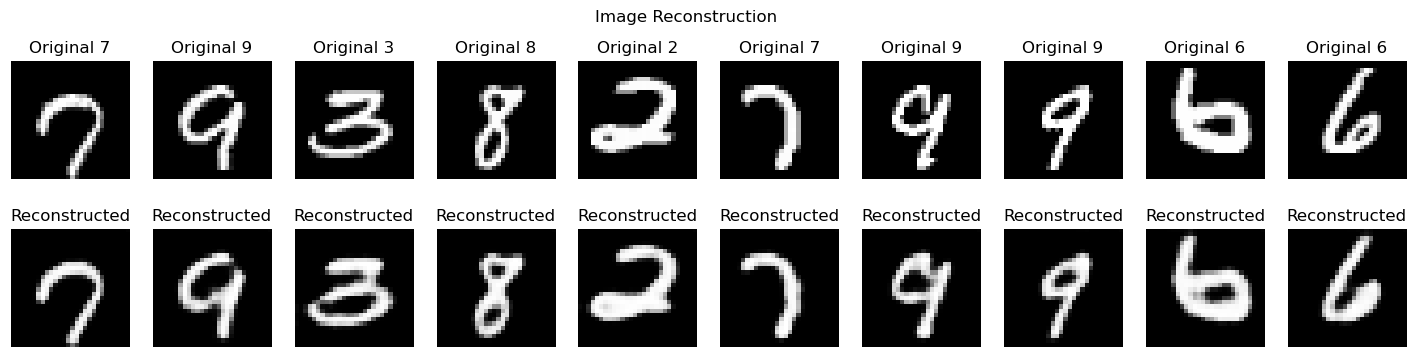

In [61]:
autoencoder.visualize_reconstructed_images(test_images, labels)

The reconstructions are fairly accurate, with slight blurring around the edges of the digits, but the digits are still easily recognizable.

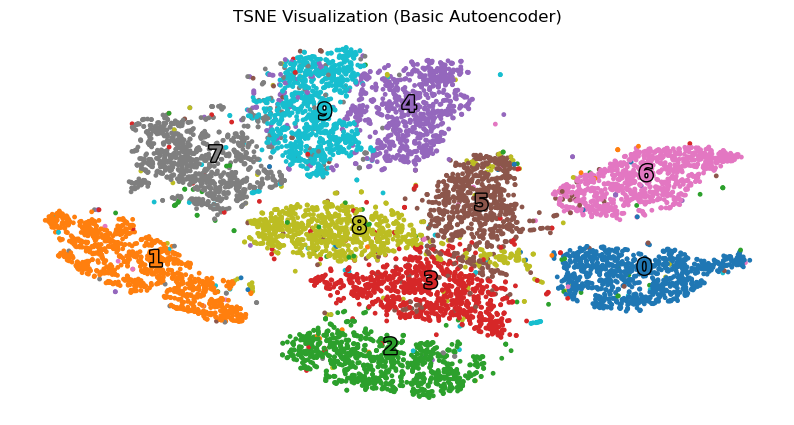

In [62]:
encoded_test_images = autoencoder.encoder(test_images).numpy()
compute_and_visualize_tsne(encoded_test_images, labels, model_name='Basic Autoencoder')

In the t-SNE representation, we observe that the different classes are fairly well-separated from each other, although there are some noisy projections that are distant from the rest of the representations belonging to the same class.

The projections for classes 1, 0, and 6 are well-distinguished from the others. However, classes 9 and 4 tend to overlap more with each other, and there are also overlaps between classes 3 and 5, as well as some projections of samples belonging to class 8.

### Denoising Autoencoder

Regarding the denoising autoencoder, we conducted two separate tests: the first one applied Gaussian noise, with mean set to 0 and a standard deviation of 0.1 to the input images, while the second one used a standard deviation of 0.5.

Both models utilized a convolutional architecture, as described in the previous section. The differences lie in the number of epochs for training, batch size, and learning rate. In the first test, we trained the model for 50 epochs, using a batch size of 1000 and a learning rate of 0.05, while in the second test, we employed 150 epochs, a batch size of 500, and a learning rate of 0.01.

#### Standar Deviation = 0.1

In [19]:
dae_sigma01 = DenoisingAutoencoder(sigma=0.1)
dae_sigma01.fit_denoising_autoencoder(train_images, mode='Adam', epochs=50, batch_size=1000, lr=0.05)

Epoch 1/50
48/48 [==============================] - 26s 511ms/step - loss: 0.0603 - val_loss: 0.0248
Epoch 2/50
48/48 [==============================] - 35s 733ms/step - loss: 0.0167 - val_loss: 0.0139
Epoch 3/50
48/48 [==============================] - 15s 318ms/step - loss: 0.0125 - val_loss: 0.0118
Epoch 4/50
48/48 [==============================] - 15s 316ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 5/50
48/48 [==============================] - 15s 303ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 6/50
48/48 [==============================] - 16s 325ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 7/50
48/48 [==============================] - 15s 312ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 8/50
48/48 [==============================] - 24s 496ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 9/50
48/48 [==============================] - 19s 377ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 10/50
48/48 [==============================] - 20s 428ms/step - loss: 0.0080 - val_lo

In [20]:
dae_sigma01.summary()

Model: "denoising_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 7, 7, 8)           1392      
                                                                 
 sequential_3 (Sequential)   (1000, 28, 28, 1)         1969      
                                                                 
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


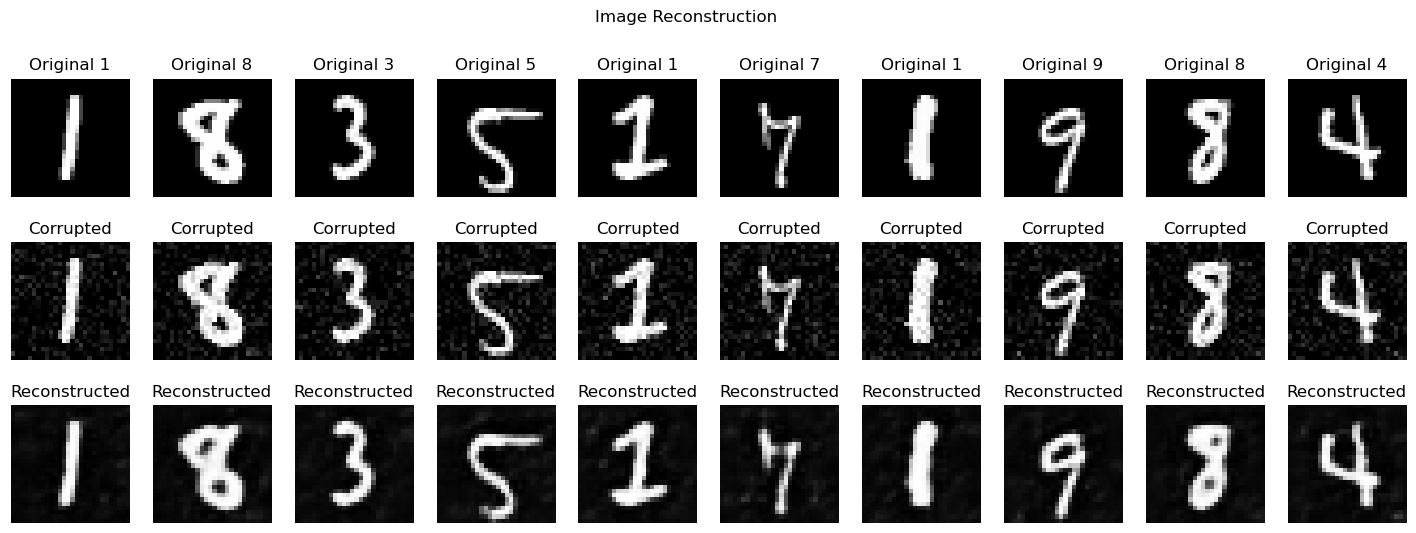

In [21]:
dae_sigma01.visualize_reconstructed_images(test_images, labels)

The reconstructions are well-done, with the autoencoder successfully removing the noise from the images. While some noise remains in the background, the lines forming the digits are clean and white.

From the reconstructions, the class of each sample can be easily identified. However, the classes were also identifiable from the noisy images.

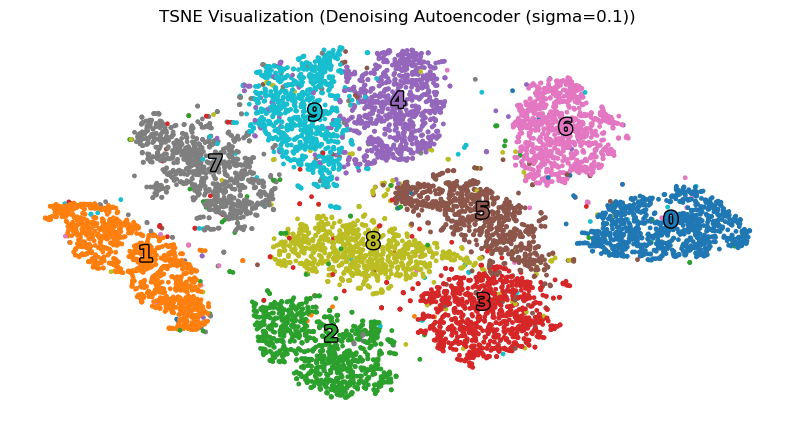

In [22]:
encoded_test_images = dae_sigma01.encoder(test_images).numpy()
compute_and_visualize_tsne(encoded_test_images, labels, model_name='Denoising Autoencoder (sigma=0.1)')

The t-SNE representation exhibits class distributions in the latent space similar to those of the previously presented autoencoder.

However, the projections corresponding to different classes are better distinguished.

We still observe some overlapping between classes 9 and 4, and between 3, 5, and 8, although to a much lesser extent compared to the previous test.

#### Standar Deviation = 0.5

Tring to train for more epochs, lowering batch size and learning rate:

In [23]:
dae_sigma05 = DenoisingAutoencoder(sigma=0.5)
dae_sigma05.fit_denoising_autoencoder(train_images, mode='Adam', epochs=150, batch_size=500, lr=0.01)

Epoch 1/150
96/96 [==============================] - 16s 157ms/step - loss: 0.1010 - val_loss: 0.0782
Epoch 2/150
96/96 [==============================] - 16s 165ms/step - loss: 0.0726 - val_loss: 0.0699
Epoch 3/150
96/96 [==============================] - 15s 155ms/step - loss: 0.0694 - val_loss: 0.0689
Epoch 4/150
96/96 [==============================] - 15s 156ms/step - loss: 0.0686 - val_loss: 0.0685
Epoch 5/150
96/96 [==============================] - 15s 155ms/step - loss: 0.0683 - val_loss: 0.0679
Epoch 6/150
96/96 [==============================] - 15s 155ms/step - loss: 0.0676 - val_loss: 0.0656
Epoch 7/150
96/96 [==============================] - 15s 154ms/step - loss: 0.0638 - val_loss: 0.0624
Epoch 8/150
96/96 [==============================] - 15s 155ms/step - loss: 0.0620 - val_loss: 0.0614
Epoch 9/150
96/96 [==============================] - 15s 155ms/step - loss: 0.0613 - val_loss: 0.0610
Epoch 10/150
96/96 [==============================] - 15s 155ms/step - loss: 0.058

In [24]:
dae_sigma05.summary()

Model: "denoising_autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 7, 7, 8)           1392      
                                                                 
 sequential_5 (Sequential)   (500, 28, 28, 1)          1969      
                                                                 
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


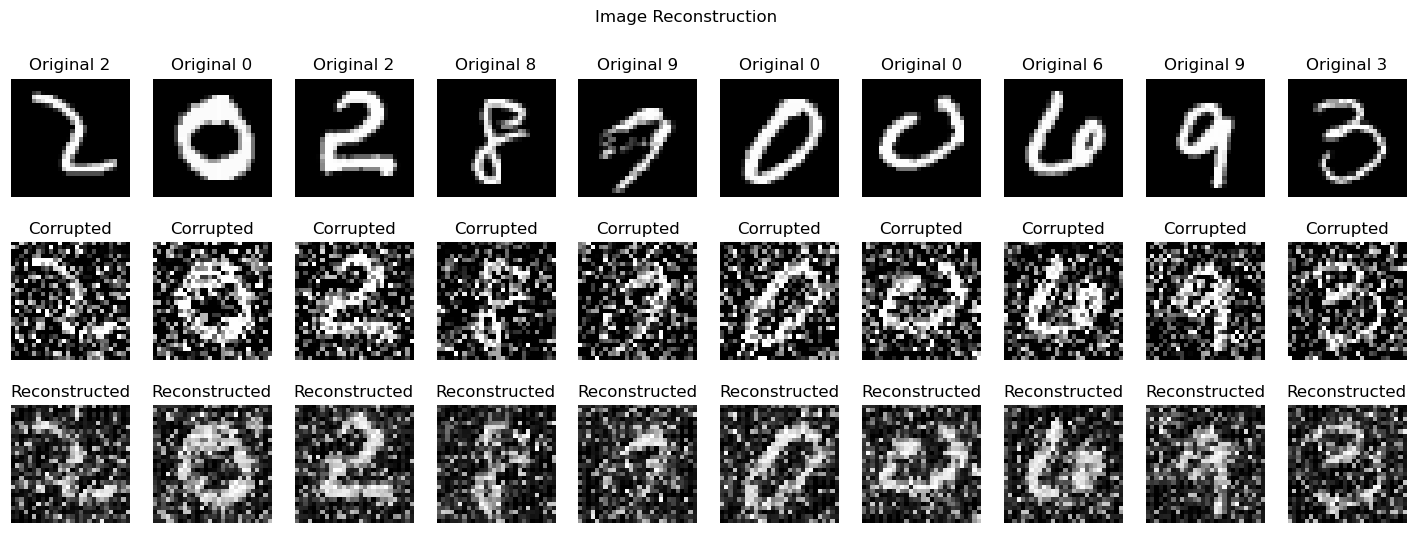

In [110]:
dae_sigma05.visualize_reconstructed_images(test_images, labels)

The input images for this test are significantly more corrupted by noise compared to the previous ones (due to the choice of noise parameters). When looking at the input images, it is challenging to distinguish the digits, especially struggling to recognize the digits from class 6 among those from class 0.

The reconstructed images are still heavily corrupted, and the autoencoder appears unable to reconstruct the original noise-free images. However, we can still observe that the parts of the images representing the digits have less noise compared to the corrupted input images.

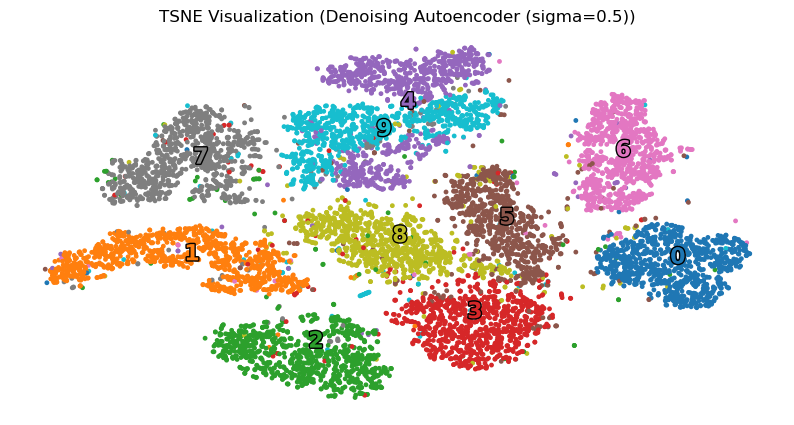

In [26]:
encoded_test_images = dae_sigma05.encoder(test_images).numpy()
compute_and_visualize_tsne(encoded_test_images, labels, model_name='Denoising Autoencoder (sigma=0.5)')

The t-SNE representation is similar to the one obtained with the first denoising autoencoder model. However, we can observe that the projections of the representations for classes 4 and 9 are completely overlapped.

There still remains a slight overlapping among the representations of classes 3, 5, and 8.

Overall, this representation is quite similar to the previous one, and we can consider the result satisfactory, considering that the input images were much more corrupted. Therefore, the autoencoder was able to effectively learn meaningful latent representations and mitigate the effects of noise in the data, demonstrating its robustness in handling highly corrupted inputs.

### Contractive Autoencoder

The last two tests were performed using two contractive autoencoders. In the first test, we utilized an architecture composed solely of dense layers, with a batch size of 1000 and a learning rate of 0.05. In the second test, we employed a convolutional architecture with a batch size of 500 and a learning rate of 0.01. Both models were trained for 50 epochs.

#### Dense Layers

In [27]:
cae = ContractiveAutoencoder(lam=1e-2, convolutional_layers=False)
cae.fit_contractive_autoencoder(train_images, mode='Adam', epochs=50, batch_size=1000, lr=0.05)

Epoch 1/50
48/48 [==============================] - 22s 377ms/step - loss: 0.0784 - val_loss: 0.0611
Epoch 2/50
48/48 [==============================] - 18s 375ms/step - loss: 0.0574 - val_loss: 0.0539
Epoch 3/50
48/48 [==============================] - 18s 374ms/step - loss: 0.0528 - val_loss: 0.0512
Epoch 4/50
48/48 [==============================] - 20s 427ms/step - loss: 0.0506 - val_loss: 0.0488
Epoch 5/50
48/48 [==============================] - 18s 368ms/step - loss: 0.0498 - val_loss: 0.0482
Epoch 6/50
48/48 [==============================] - 29s 604ms/step - loss: 0.0473 - val_loss: 0.0460
Epoch 7/50
48/48 [==============================] - 27s 574ms/step - loss: 0.0443 - val_loss: 0.0450
Epoch 8/50
48/48 [==============================] - 20s 424ms/step - loss: 0.0416 - val_loss: 0.0401
Epoch 9/50
48/48 [==============================] - 19s 398ms/step - loss: 0.0398 - val_loss: 0.0390
Epoch 10/50
48/48 [==============================] - 18s 382ms/step - loss: 0.0391 - val_lo

In [28]:
cae.summary()

Model: "contractive_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (1000, 32)                110816    
                                                                 
 sequential_7 (Sequential)   (1000, 28, 28)            111568    
                                                                 
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 0
_________________________________________________________________


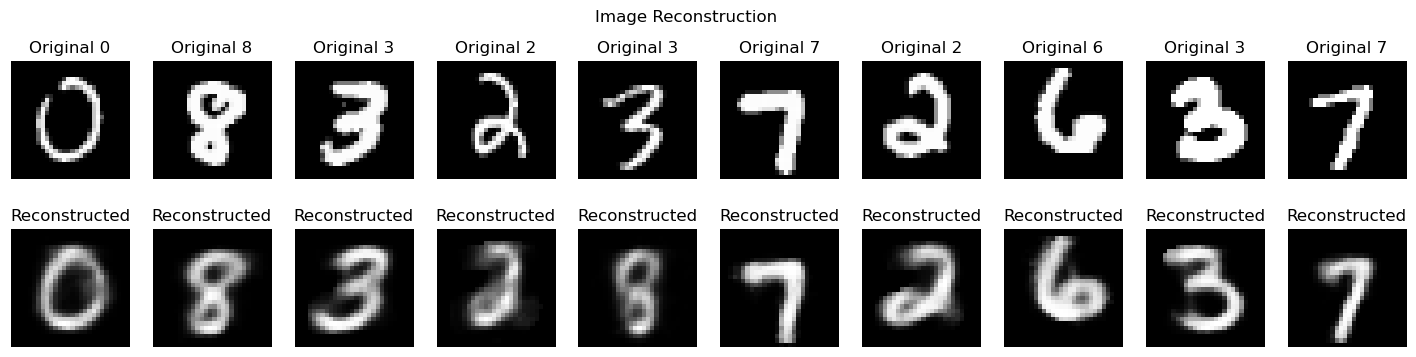

In [29]:
cae.visualize_reconstructed_images(test_images, labels)

The reconstructed images exhibit significant blurring compared to the inputs, and it's noticeable that the reconstructed digits appear to have thinner strokes than the originals.

Additionally, we can notice that in the fifth example of reconstruction, whose target belongs to class 3, the reconstruction resembles an eight.

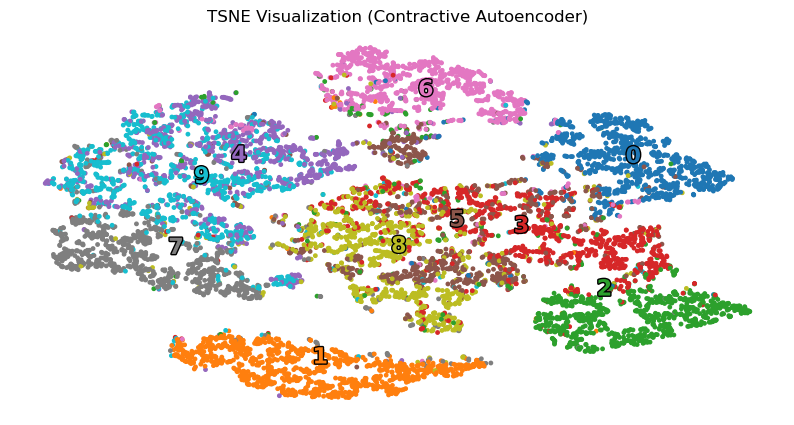

In [30]:
encoded_test_images = cae.encoder(test_images).numpy()
compute_and_visualize_tsne(encoded_test_images, labels, model_name='Contractive Autoencoder')

The t-SNE representation appears much more cluttered compared to the representations obtained from the other models.

We don't observe a clear aggregation of the projections of representations belonging to a single class at a specific point, but rather the representations are more scattered throughout the space.

There remains a significant overlap between classes 4 and 9, and between 3, 5, and 8, even more so than the other representations.

#### Convolutional Layers

In [99]:
cae_conv = ContractiveAutoencoder(lam=1e-2)
cae_conv.fit_contractive_autoencoder(train_images, mode='Adam', epochs=50, batch_size=500, lr=0.01)

Epoch 1/50
96/96 [==============================] - 41s 406ms/step - loss: 0.0614 - val_loss: 0.0147
Epoch 2/50
96/96 [==============================] - 40s 422ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 3/50
96/96 [==============================] - 44s 462ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 4/50
96/96 [==============================] - 44s 458ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 5/50
96/96 [==============================] - 44s 458ms/step - loss: 0.0060 - val_loss: 0.0066
Epoch 6/50
96/96 [==============================] - 55s 575ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 7/50
96/96 [==============================] - 63s 662ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 8/50
96/96 [==============================] - 68s 715ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 9/50
96/96 [==============================] - 46s 484ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 10/50
96/96 [==============================] - 32s 337ms/step - loss: 0.0051 - val_lo

In [32]:
cae_conv.summary()

Model: "contractive_autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 7, 7, 8)           1392      
                                                                 
 sequential_9 (Sequential)   (1000, 28, 28, 1)         1969      
                                                                 
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


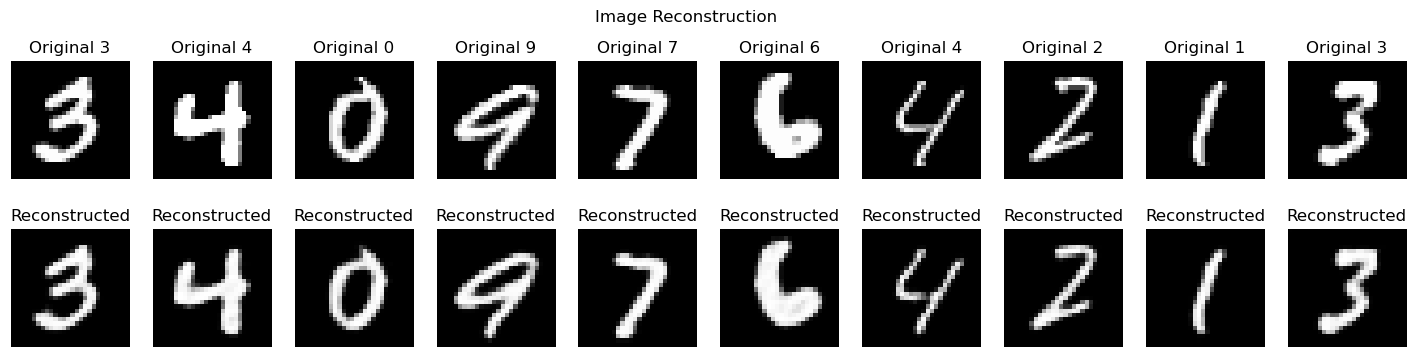

In [100]:
cae_conv.visualize_reconstructed_images(test_images, labels)

The reconstructions are good, very similar to the input images for all digits, clearly of higher quality compared to those obtained without the use of the convolutional architecture.

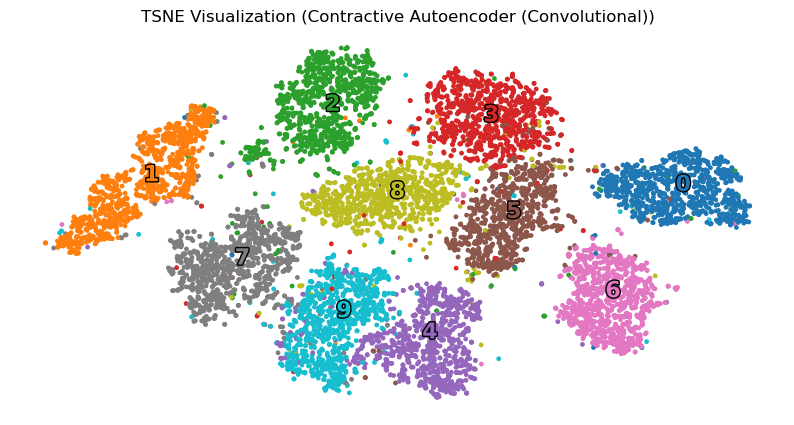

In [101]:
encoded_test_images = cae_conv.encoder(test_images).numpy()
compute_and_visualize_tsne(encoded_test_images, labels, model_name='Contractive Autoencoder (Convolutional)')

Even concerning the t-SNE representations, it's better, and the representations of digits belonging to the same class are found in a single point, similar to the representations obtained from other convolutional architectures.

However, unlike all the other t-SNE representations where the relative position between the centroids of the projections of different classes remains approximately constant in space, in this representation, the projections of distinct classes in the latent space have different positions from each other.

Nevertheless, we still observe a slight overlapping between classes 4 and 9 and between classes 3, 5, and 8.

## Iterative gradient ascent process to generate images

In this section, we demonstrate the iterative gradient ascent process used to generate images. 

The initial random noise image, generated with the same dimensions as the dataset images, serves as the starting point. This random noise image is created by sampling pixel values from a uniform distribution.

The purpose of this process is to illustrate how the autoencoder, trained on our dataset, can transform random noise into a structured image by leveraging its learned representations.

Below are the plots illustrating how the image evolves during the gradient ascent process for each model we trained.

In [85]:
random_noise_image = np.random.normal(0, 1, (28, 28))

### Basic autoencoder

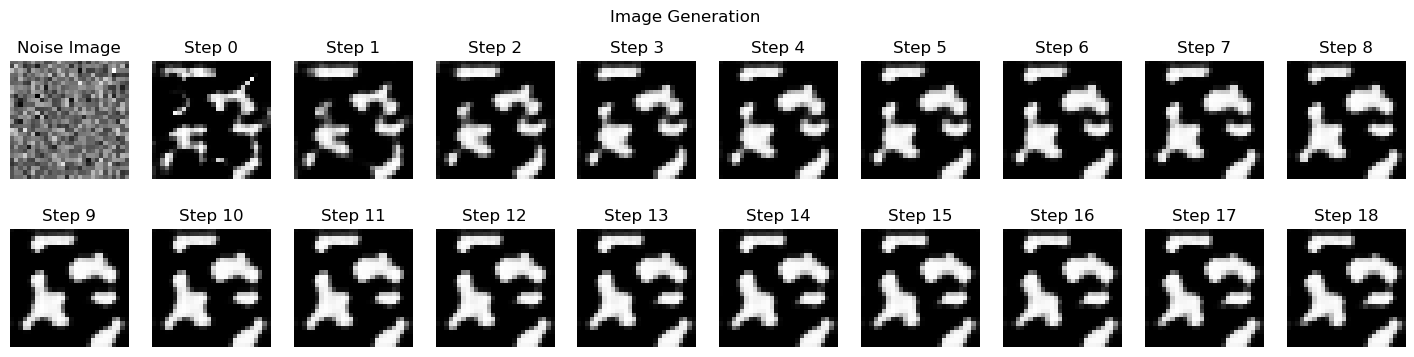

In [115]:
gradient_ascent(autoencoder, random_noise_image, n_steps=19, delta_steps=1, lr=0.01)

Using the basic autoencoder, we applied the gradient ascent process to a random noise image. After the first iteration, the output image begins to resemble the digit 3. From the second iteration onwards, the changes are minimal, suggesting that the algorithm has reached convergence.

### DAE std=0.1

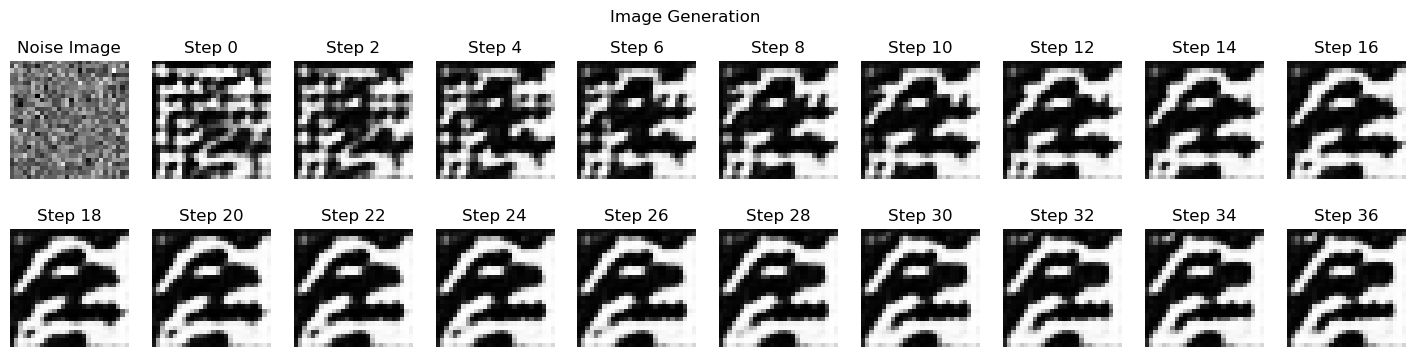

In [117]:
gradient_ascent(dae_sigma01, random_noise_image, n_steps=38, delta_steps=2, lr=0.05)

In the image above, we visualize the results of the test performed using the denoising autoencoder with a standard deviation of 0.1 for the Gaussian noise.

Throughout the iterations, the output image begins to form some identifiable patterns, but none of the generated images resemble any specific digit clearly. The process demonstrates some denoising capability, but the results remain ambiguous and lack definitive structure.

### DAE std=0.5

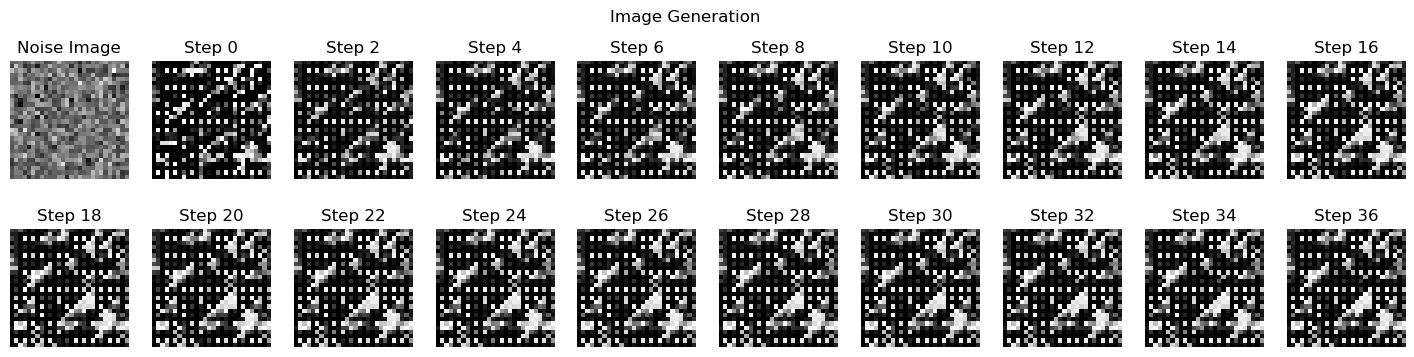

In [123]:
gradient_ascent(dae_sigma05, random_noise_image, n_steps=38, delta_steps=2, lr=0.5)

For the test using the denoising autoencoder with a standard deviation of 0.5 for the added Gaussian noise, even after several iterations, the images remain significantly noisy, with only faint, repetitive patterns emerging. These patterns do not resemble any recognizable digits and appear to be artifacts, potentially caused by the convolutional kernel size. The output continues to be dominated by noise, indicating limited denoising effectiveness at this higher noise level.

### CAE Dense layers

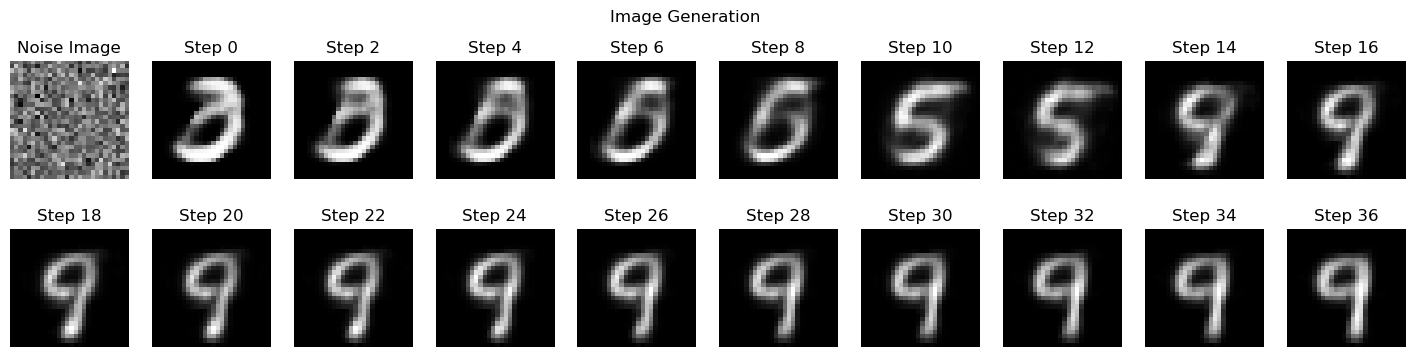

In [125]:
gradient_ascent(cae, random_noise_image, n_steps=38, delta_steps=2, lr=0.01)

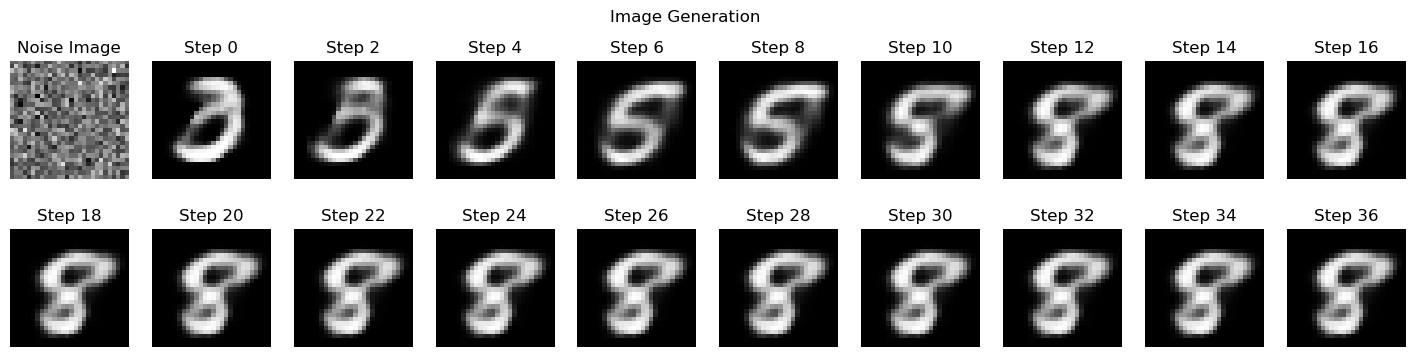

In [122]:
gradient_ascent(cae, random_noise_image, n_steps=38, delta_steps=2, lr=0.4)

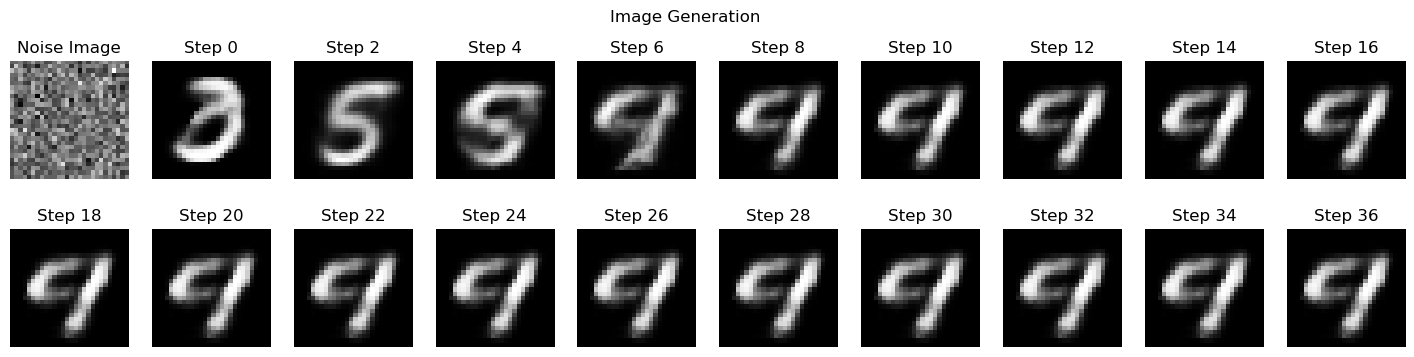

In [89]:
gradient_ascent(cae, random_noise_image, n_steps=38, delta_steps=2, lr=2.4)

We conducted three different tests with varying learning rates using the contractive autoencoder with dense layers. 

Across all tests, we observed an evolution of the generated image starting from an image resembling either a 0 or a 3 in the initial iterations, transitioning through 5, and eventually converging to an image resembling the digit 9 or 8.

Differences in output among the tests were influenced by the chosen learning rates. A higher learning rate facilitated faster convergence but might introduce undesired oscillations, while a lower learning rate required more iterations but produced clearer final images. As evidenced in the test conducted using learning rates of 0.01 and 2.4 respectively, both images converged to resemble the digit 9, but the former appeared clearer and less blurred.

Utilizing architectures with dense layers generally yielded visually superior results for image generation. Dense autoencoders capture more intricate data relationships, enabling the generation of richer, more detailed image representations and consequently leading to better reconstruction and generation of realistic images.

### CAE Convolutional Layers

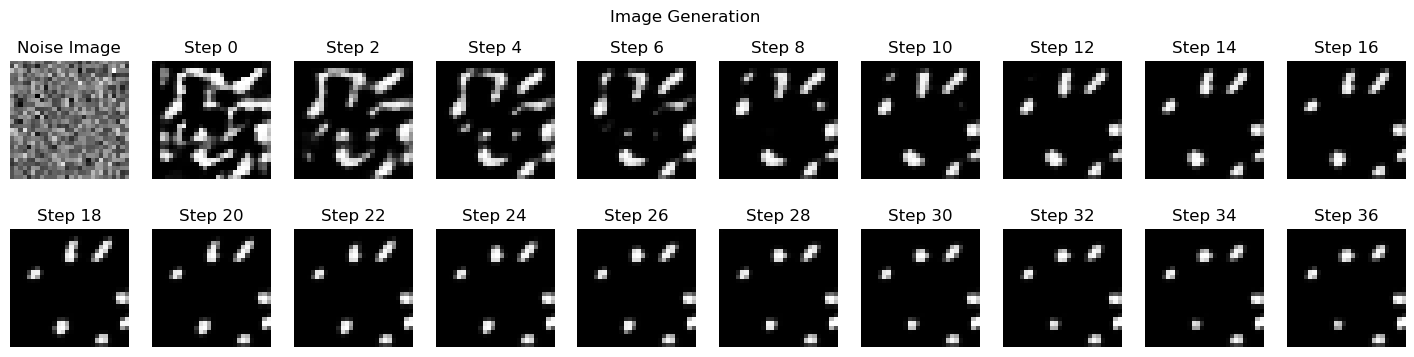

In [126]:
gradient_ascent(cae_conv, random_noise_image, n_steps=38, delta_steps=2, lr=0.1)

In the initial iterations, the generated image seems to pull out complex patterns, but it then converges to an image containing only small oval patches, which cannot be attributed to any specific digit.

This behavior indicates a potential limitation in the ability of the convolutional autoencoder to capture and reconstruct meaningful features from the data, resulting in ambiguous and unrecognizable final images.

These observations are consistent with the results obtained from other models utilizing a convolutional architecture, suggesting a common challenge in effectively capturing and representing features in the dataset and using them to generate new data.

### t-SNE representation

We also visualize the placement of the encoded noise image alongside the representations of the encoded test images in the latent space of the t-SNE representation, to observe where the noise image was positioned for each trained model.

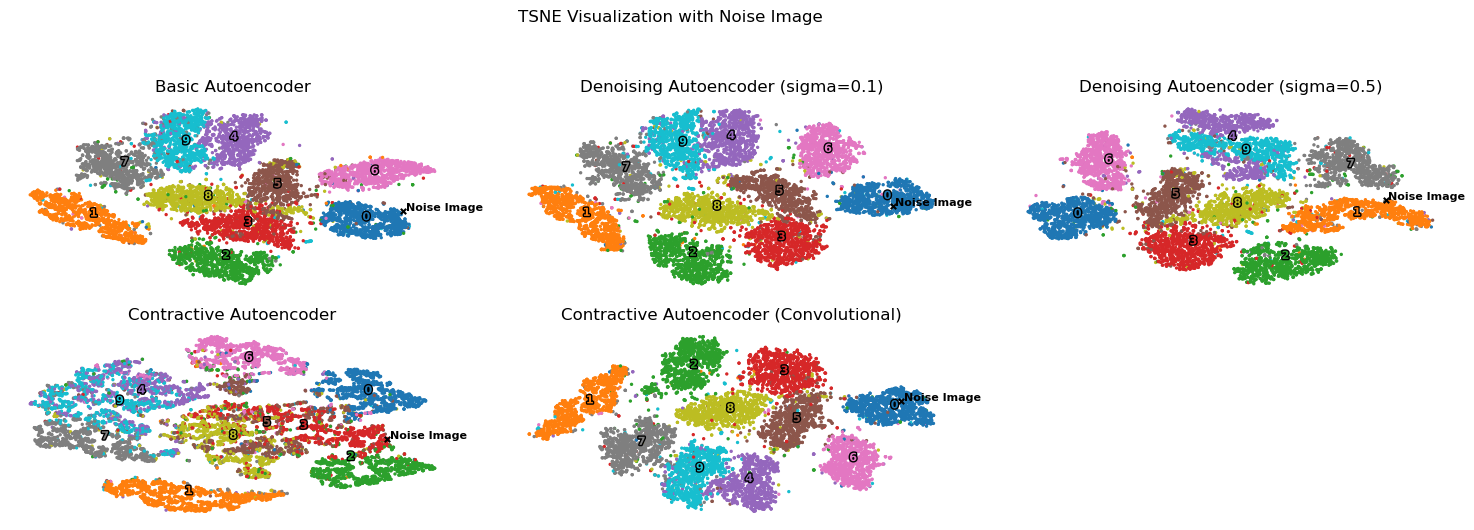

In [106]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i, (model, model_name) in enumerate(zip([autoencoder, dae_sigma01, dae_sigma05, cae, cae_conv],
    ['Basic Autoencoder', 'Denoising Autoencoder (sigma=0.1)', 'Denoising Autoencoder (sigma=0.5)',
    'Contractive Autoencoder', 'Contractive Autoencoder (Convolutional)'])):
    encoded_noise_image = model.encoder(random_noise_image.reshape(1, 28, 28)).numpy()
    encoded_test_images = model.encoder(test_images).numpy()

    ax = axs.flatten()[i]
    ax = visualize_noise_image_on_tsne(encoded_test_images, labels, encoded_noise_image, model_name, ax)

axs.flatten()[-1].axis('off')
fig.suptitle('TSNE Visualization with Noise Image', x=0.45, y=1.05)
plt.tight_layout()
plt.show()

The representation of the noise image is projected amidst the representations of digit 0 in most cases, except for the denoising autoencoder where additional noise was introduced, and for the contractive autoencoder with dense layers, which is located elsewhere.

## Conclusion and Final Considerations

In conclusion, the analysis demonstrates the effectiveness of various autoencoder architectures in reconstructing images and capturing meaningful representations in the latent space. 

While **convolutional architectures generally outperform dense architectures**, in termini di loss function and image recostruction of an input, the performance varies depending on factors such as noise levels and model complexity. 

Additionally, t-SNE representations offer valuable insights into the clustering of digit classes in the latent space, although some overlap persists between certain classes.

Overall, these findings underscore the importance of choosing appropriate architectures and parameters based on specific task requirements for optimal performance in image reconstruction and representation learning tasks.

From the analysis conducted on the **iterative gradient ascent process**, it can be concluded that **convolutional autoencoders generally struggle to generate new images from noise inputs**, often resulting in ambiguous and unrecognizable final images. This is evident from the convergence to images containing only small oval patches, which cannot be attributed to any specific digit.

While **denoising autoencoders with dense layer architectures** may show some **capability in producing new data from noise**.

We are **unable to definitively determine** whether **contractive or denoising autoencoders are superior for these tasks**. This is because the true **difference in performance seems to be attributed** to the architecture of the encoder and decoder, with **dense layers and convolutions** rather than.

The positioning of the noise image in the t-SNE rappresentation of the encodend image from the test set amidst the representations of digit 0 in most cases indicates that the models tend to encode noise images similarly to digit 0. However, exceptions exist, such as the denoising autoencoder with added noise and the contractive autoencoder with dense layers, highlighting the variability in how different models handle noise representations.

Following these analyses, it can be concluded that **if we aim to use autoencoders as generative models, an architecture with dense layers might be the better choice** as the generated images exhibit superior quality, allowing for easy visualization of digits and the possibility of achieving images comparable to those of the MNIST dataset with careful hyperparameter selection.

On the other hand, **if the goal of the autoencoder is to reduce the dimensionality of input data and extract the most relevant features** for each image, implementing **an architecture with convolutional layers seems preferable**. Indeed, a limitation of dense architectures is the lack of a clear division of representations for each class in the latent space, as highlighted by the t-SNE visualization. This is reflected in the image generation process, where images appear to resemble different digits before converging.

In contrast, examining the **t-SNE representations reveals that convolutional architectures** are capable of **separating features extracted from images belonging to different classes in the latent space**. This suggests a good ability of these models to extract meaningful latent information for each distinct class, **making latent representations a good compression of input data**.

possiamo concludere che per il task di riduzione di dimensionalità e estrazione di important features la scelta di ae denoising o contractive deve dipendere dai paramentri specifici dalle immagini in input

In conclusion, for the **task of dimensionality reduction and extraction of important features**, the **choice between denoising or contractive autoencoders** should depend on the specific parameters of the input images. However, this decision **should be made using selection criteria** that measure the quality of divisions between the clusterings of **representations of different classes in the latent space**, utilizing appropriate metrics.